# Feature Engineering

<hr>

## Introduction

In this course you'll learn about one of the most important steps on the way to building a great machine learning model: feature engineering. You'll learn how to:

- determine which features are the most important with mutual information
- invent new features in several real-world problem domains
- encode high-cardinality categoricals with a target encoding
- create segmentation features with k-means clustering
- decompose a dataset's variation into features with principal component analysis

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

concrete = pd.read_csv("concrete.csv")

**The ```.pop()``` method returns removed value from the list**

Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

In [2]:
X = concrete.copy()

y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


If you ever cook at home, you might know that the ratio of ingredients in a recipe is usually a better predictor of how the recipe turns out than their absolute amounts. We might reason then that ratios of the features above would be a good predictor of ```CompressiveStrength```

In [3]:
X = concrete.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


<hr>

## Mutual Information

The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

**Interpreting Mutual Information Scores**

The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

**Here are some things to remember when applying mutual information:**

- MI can help you to understand the relative potential of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a univariate metric.
- The actual usefulness of a feature depends on the model you use it with. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

auto = pd.read_csv("autos.csv")
auto.head()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


- ```X[colname].factorize()```: This function encodes the categorical values as integers. Each unique value in the column is assigned a unique integer. For example, if a column has values ```["cat", "dog", "cat"]```, after factorization, it might be encoded as ```[0, 1, 0]```.
- ```X[colname], _```: The ```factorize()``` method returns two values: the encoded values and an array of the unique values that were found (the factorization "categories"). The underscore ```_``` is used to ignore the second returned value because we don't need the array of unique values in this context.

In [6]:
X = auto.copy()
y = X.pop("price")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

Scikit-learn has two mutual information metrics in its ```feature_selection``` module: one for real-valued targets ```(mutual_info_regression)``` and one for categorical targets ```(mutual_info_classif)```. Our target, ```price```, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [7]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

curb_weight          0.914087
highway_mpg          0.880874
length               0.606081
fuel_system          0.465321
drive_wheels         0.332490
peak_rpm             0.221353
compression_ratio    0.115622
fuel_type            0.048139
Name: MI Scores, dtype: float64

**Visualizing**

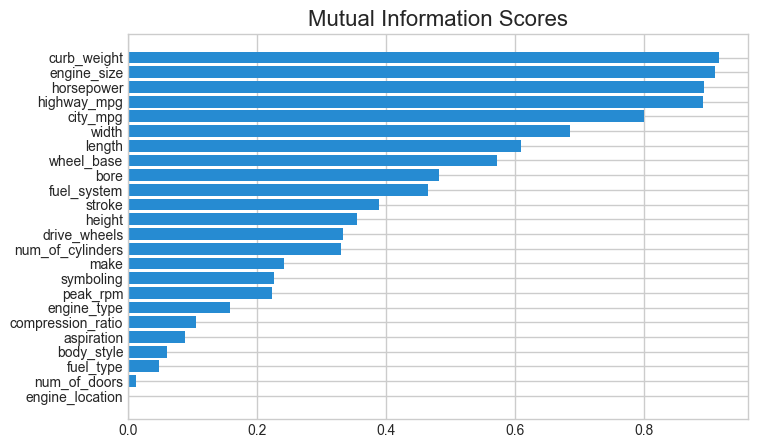

In [40]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

<hr>

## Creating Features

In the Automobile dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [8]:
auto["stroke_ratio"] = auto.stroke / auto.bore

auto[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of WindSpeed in US Accidents is highly skewed, for instance. In this case the logarithm is effective at normalizing it

<Axes: xlabel='LogWindSpeed', ylabel='Density'>

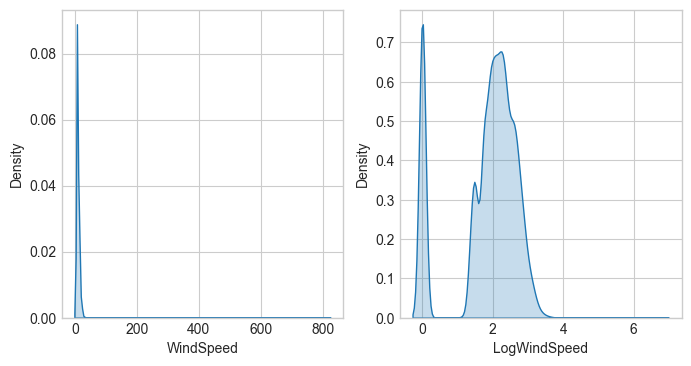

In [10]:
accidents = pd.read_csv("accidents.csv")

# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents.WindSpeed.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents.WindSpeed, fill=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, fill=True, ax=axs[1])

**Counts**

In the right column we get the sum of it all

In [11]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


**The ```gt()``` method compares each value in a DataFrame to check if it is greater than a specified value, or a value from a specified DataFrame objects, and returns a DataFrame with boolean True/False for each comparison.**

We want to count for each row the number of components in the concrete

In [12]:
components = [ "Cement", "BlastFurnaceSlag", "FlyAsh", "Water",
               "Superplasticizer", "CoarseAggregate", "FineAggregate"]
concrete["Components"] = concrete[components].gt(0).sum(axis=1)

concrete[components + ["Components"]].head(10)

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Components
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,5
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,5
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,5
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,5
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,5
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,5
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,4


<hr>

## Building-Up and Breaking-Down Features

**The ```str``` accessor lets you apply string methods like ```split``` directly to columns**

In [15]:
customer = pd.read_csv("customer.csv", index_col=0)
customer.head()

,Customer,State,CustomerLifetimeValue,Response,Coverage,Education,EffectiveToDate,EmploymentStatus,Gender,Income,...,MonthsSincePolicyInception,NumberofOpenComplaints,NumberofPolicies,PolicyType,Policy,RenewOfferType,SalesChannel,ClaimAmount,VehicleClass,VehicleSize
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,...,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,...,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [16]:
customer[["Type", "Level"]] = (  # Create two new features
    customer["Policy"]           # from the Policy feature
    .str                         # through the string accessor
    .split(" ", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

customer[["Policy", "Type", "Level"]].head(10)

,Policy,Type,Level
0,Corporate L3,Corporate,L3
1,Personal L3,Personal,L3
2,Personal L3,Personal,L3
3,Corporate L2,Corporate,L2
4,Personal L1,Personal,L1
5,Personal L3,Personal,L3
6,Corporate L3,Corporate,L3
7,Corporate L3,Corporate,L3
8,Corporate L3,Corporate,L3
9,Special L2,Special,L2


You could also join simple features into a composed feature if you had reason to believe there was some interaction in the combination

In [18]:
autos = pd.read_csv("autos.csv")
autos["make_and_style"] = autos["make"] + "_" + autos["body_style"]
autos[["make", "body_style", "make_and_style"]].head()

,make,body_style,make_and_style
0,alfa-romero,convertible,alfa-romero_convertible
1,alfa-romero,convertible,alfa-romero_convertible
2,alfa-romero,hatchback,alfa-romero_hatchback
3,audi,sedan,audi_sedan
4,audi,sedan,audi_sedan


<hr>

## Group Transforms

In [19]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]                 # select the income
    .transform("mean")         # and compute its mean
)

customer[["State", "Income", "AverageIncome"]].head(10)

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
5,Oregon,62902,37557.283353
6,Oregon,55350,37557.283353
7,Arizona,0,37405.402231
8,Oregon,14072,37557.283353
9,Oregon,28812,37557.283353


You could use a transform like this to create a "frequency encoding" for a categorical feature.

In [20]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count() #basically total number of states (rows) in a df
)

customer[["State", "StateFreq"]].head(10)

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
5,Oregon,0.284760
6,Oregon,0.284760
7,Arizona,0.186446
8,Oregon,0.284760
9,Oregon,0.284760


If you're using training and validation splits, to preserve their independence, it's best to create a grouped feature using only the training set and then join it to the validation set. We can use the validation set's merge method after creating a unique set of values with drop_duplicates on the training set

In [21]:
# Create splits
df_train = customer.sample(frac=0.5)
df_valid = customer.drop(df_train.index)

# Create the average claim amount by coverage type, on the training set
df_train["AverageClaim"] = df_train.groupby("Coverage")["ClaimAmount"].transform("mean")

# Merge the values into the validation set
df_valid = df_valid.merge(
    df_train[["Coverage", "AverageClaim"]].drop_duplicates(),
    on="Coverage",
    how="left",
)

df_valid[["Coverage", "AverageClaim"]].head(10)

,Coverage,AverageClaim
0,Basic,374.945919
1,Extended,481.302740
2,Basic,374.945919
3,Basic,374.945919
4,Basic,374.945919
5,Basic,374.945919
6,Premium,657.678509
7,Basic,374.945919
8,Basic,374.945919
9,Basic,374.945919


**Tips on Creating Features**

- Linear models learn sums and differences naturally, but can't learn anything more complex.
- Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
- Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
- Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
- Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

### Task

If you've discovered an interaction effect between a numeric feature and a categorical feature, you might want to model it explicitly using a one-hot encoding, like so:

In [ ]:
# One-hot encode Categorical feature, adding a column prefix "Cat"
X_new = pd.get_dummies(df.Categorical, prefix="Cat")

# Multiply row-by-row
X_new = X_new.mul(df.Continuous, axis=0)

# Join the new features to the feature set
X = X.join(X_new)

<hr>

# Unsupervised Learning - decided to carry on Later

## Clustering With K-Means